In [1]:
import pandas as pd

In [2]:
db = pd.read_json("data/martin_result.json")

In [3]:
def concat(li):
    res = []
    for i in li:
        res += i
    return res


def split_others(string):
    string = string.strip(" ,").replace(",", " ")
    return string.split(" ") if len(string) >= 1 else []
    

In [4]:
db.head(3)

,id,annotations,file_upload,drafts,predictions,data,meta,created_at,updated_at,inner_id,total_annotations,cancelled_annotations,total_predictions,comment_count,unresolved_comment_count,last_comment_updated_at,project,updated_by,comment_authors
0,831,"[{'id': 163, 'completed_by': 5, 'result': [{'v...",6d0d8abb-linking_ls_v5_martin.json,[],[],"{'text': '<pre style=""white-space: pre-wrap;"">...",{},2024-04-26 06:16:34.645723+00:00,2024-05-08 05:16:47.304226+00:00,1,1,0,0,0,0,NaT,19,5,[]
1,832,"[{'id': 164, 'completed_by': 5, 'result': [{'v...",6d0d8abb-linking_ls_v5_martin.json,[],[],"{'text': '<pre style=""white-space: pre-wrap;"">...",{},2024-04-26 06:16:34.645792+00:00,2024-05-08 05:17:50.954528+00:00,2,1,0,0,0,0,NaT,19,5,[]
2,833,"[{'id': 165, 'completed_by': 5, 'result': [{'v...",6d0d8abb-linking_ls_v5_martin.json,[],[],"{'text': '<pre style=""white-space: pre-wrap;"">...",{},2024-04-26 06:16:34.645834+00:00,2024-05-08 05:21:23.392518+00:00,3,1,0,0,0,0,NaT,19,5,[]


In [5]:
print(db["annotations"].apply(lambda x: len(x)).max())
print(db["annotations"].apply(lambda x: len(x)).min())

1
1


In [6]:
result_db = pd.DataFrame()
result_db["choices"] = db["annotations"].apply(lambda x: concat([i["value"].get("choices", []) for i in x[0]["result"]
                                                                 if i["from_name"] == "dynamic_choices"]))

result_db["other_ids"] = db["annotations"].apply(lambda x: split_others("".join(concat([i["value"].get("text", []) for i in x[0]["result"]
                                                                            if i["from_name"] == "ta_other_ids"]))))

result_db["note"] = db["annotations"].apply(lambda x: "".join(concat([i["value"].get("text", []) for i in x[0]["result"]
                                                                      if i["from_name"] == "ta_note"])))

result_db.index = db["data"].apply(lambda x: int(x["annid"]))

In [7]:
result_db.head(3)

,choices,other_ids,note
data,,,
2860,[L01CD01],[],
3004,[L01FD01],[],
79,[],[DB01229],taxol je paxlitaxel


In [8]:
result_db[result_db["choices"].apply(lambda x: len(x) > 1)]

,choices,other_ids,note
data,,,
380,"[A04A, A04AA55]",[],
2471,"[D009558, D002921]",[],
5571,"[D012119, D000005]","[D001831, D010528, D004487]",afebrilní - bez teploty - mash telesná teplota...


In [9]:
result_db[result_db["other_ids"].apply(lambda x: len(x) >= 1)].head(10)

,choices,other_ids,note
data,,,
79,[],[DB01229],taxol je paxlitaxel
4394,[],[DB01009],
2233,[],[D08AJ],
1620,[],[D08AJ],
298,[],[D007938],"obecný kód pro leukemie výše, to co vybralo je..."
546,[D003560],[D011151],konkrétně Bakerova cysta je popliteální cysta
3865,[D012272],[D012253],
928,[D007044],"[D010052, M0360933]",většinou se dělá oboustrnná adnexektomie/ovare...
2969,[D061865],"[D006484, D013514]",odstranení hemoroidů není jediná operační možn...


In [10]:
all_explanation = pd.DataFrame()

for path in ["labeling_doctors/medikace_with_empty.json",
             "labeling_doctors/ne_medikace_with_empty.json",
             "labeling_doctors/ne_symptom_with_empty.json",
             "labeling_doctors/ne_osobni_with_empty.json",
             "labeling_doctors/osobni_with_empty.json",
             "labeling_doctors/procedura_with_empty.json",
             "labeling_doctors/symptom_with_empty.json",
            ]:
    dtb = pd.read_json(path)
    all_explanation = pd.concat([all_explanation, dtb])

print(len(all_explanation))
print(len(all_explanation[(all_explanation["label"] == "medikace") | (all_explanation["label"] == "NE medikace")]))
print(len(all_explanation[~(all_explanation["label"] == "medikace") & ~(all_explanation["label"] == "NE medikace")]))

all_explanation.sample(3, random_state=43)

244
57
187


,label,text,shortcuts,original_text,explanation
1620,NE medikace,ajatin,,ajatin,"{'ajatin': ['S01AX', 'JINÁ ANTIINFEKTIVA', '1']}"
1367,NE symptom,bez dilatace žlučových cest,,bez dilatace žlučových cest,"{'žlučových cest': ['D018285', 'Klatskinův nád..."
4229,NE osobní anamnéza,CA bez kompl,,CA bez kompl,"{'kompl': ['D000093182', 'komplexní metabolick..."


In [11]:
linking_and_result = all_explanation.join(result_db, how="inner")
print(len(linking_and_result))
linking_and_result.sample(3, random_state=42)

109


,label,text,shortcuts,original_text,explanation,choices,other_ids,note
736,procedura,UZ prsou,,UZ prsou,"{'prsou': ['D008327', 'mamografie', 'Radiograf...",[],"[M0022235, D001940]",ultrasonografie + prsy
306,medikace,zoladex 3 6 MG,,"zoladex 3,6 MG","{'zoladex': ['L02AE03', 'GOSERELIN', '2']}",[L02AE03],[],
240,medikace,inhibitor aromatázy,,inhibitor aromatázy,"{'inhibitor aromatázy': ['L02BG', 'INHIBITORY ...",[L02BG],[],


In [12]:
NILL = pd.DataFrame()

for category, num in [("medikace", 17), ("NE symptom", 17), ("symptom", 17), ("osobní anamnéza", 17), ("NE osobní anamnéza", 17), ("procedura", 17), ("NE medikace", 7)]:
    temp = all_explanation[all_explanation["label"] == category]
    till_index = temp[temp["explanation"].apply(lambda x: len(x) != 0)].iloc[:num].index[-1]
    temp = all_explanation[all_explanation["label"] == category].loc[:till_index]
    temp = temp[temp["explanation"].apply(lambda x: len(x) == 0)]
    NILL = pd.concat([NILL, temp])

NILL["choices"] = NILL.apply(lambda x: [], axis=1)
NILL["other_ids"] = NILL.apply(lambda x: [], axis=1)
NILL["note"] = ""
linking_and_result = pd.concat([linking_and_result, NILL])

NILL.at[139, "other_ids"] = ["L01DB03", "L01AA01"]
NILL.at[3526, "other_ids"] = ["D001365", "D008198"]
NILL.at[1110, "other_ids"] = ["D011790"]
NILL.at[1040, "other_ids"] = ["D020246"]
NILL.at[134, "other_ids"] = ["D009203"]
NILL.at[2536, "other_ids"] = ["D009422"]
NILL.at[5463, "other_ids"] = ["G03"]
NILL.at[5586, "other_ids"] = ["G03"]
NILL.at[53, "other_ids"] = ["G03A"]

NILL

,label,text,shortcuts,original_text,explanation,choices,other_ids,note
139,medikace,EC,,EC,{},[],"[L01DB03, L01AA01]",
3526,NE symptom,v axile LU dnes LU nehmatám,,v axile LU dnes LU nehmatám,{},[],"[D001365, D008198]",
1110,NE symptom,karanténě není,,karanténě není,{},[],[D011790],
1992,NE symptom,,b v f,b.v.f,{},[],[],
4945,symptom,tu ložisko,,tu ložisko,{},[],[],
1264,NE osobní anamnéza,s ničím neléčí,,s ničím neléčí,{},[],[],
1040,NE osobní anamnéza,DVT 0,,DVT 0,{},[],[D020246],
134,NE osobní anamnéza,IM 0,,IM 0,{},[],[D009203],
2536,NE osobní anamnéza,neurologická onemocnění,,neurologická onemocnění,{},[],[D009422],
5463,NE medikace,bez HRT,,bez HRT,{},[],[G03],


In [13]:
temp = linking_and_result[linking_and_result.apply(lambda x: len(x.choices) + len(x.other_ids) == 0, axis=1)].copy()
temp["inx"] = temp.index
temp.apply(lambda x: print(x.inx, x.note) if x.note != "" else None, axis=1)
None

2345 An abbreviation for a chemotherapy combination used with other types of therapy to treat breast cancer, including breast cancer that has spread or come back. It includes the drugs doxorubicin hydrochloride (Adriamycin) and cyclophosphamide. Also called AC.
3356 sine znamená latinsky: bez/beze
2463 hormonální je nejen onkologická, viz. celé ATC skupiny G, H
2036 zn. aktuálně již vysazeno
856 hormonální je nejen onkologická, viz. celé ATC skupiny G, H
5614 bez známek zánětu - nenašel jsem mash
2400 napětí kůže, hodnotí se stav hydratace -  nenašel jsem mash
993 nevím jestli existuje mesh pro zdraví
444 nenašel jsem kód na obecnou operaci, totální endoprotézu kolene to trefilo úplnou náhodou, není to v oranžové části
5926 HYE - hysterektomie D007044, AE - adnexektomie D010052 (ovarektomie)
4998 UDH - usual ductal hyperplasia, pro hyperplazii kod M0010849
3894 pro Ca - pro karcinom/zhoubný novotvar
1845 nejsem schopen najít mesh na ložiská jater
4517 nevím co je ITP
873 nejsem schopen

In [14]:
linking_and_result.at[2345, "other_ids"] = ["L01DB01", "L01AA01"]
linking_and_result.at[5926, "other_ids"] = ["D007044", "D010052"]
linking_and_result.at[4998, "other_ids"] = ["M0010849"]

In [15]:
temp = linking_and_result[linking_and_result["note"] != ""].copy()
temp["inx"] = temp.index
temp.apply(lambda x: print(x.inx, x.note) if x.note != "" else None, axis=1)
temp

79 taxol je paxlitaxel
2345 An abbreviation for a chemotherapy combination used with other types of therapy to treat breast cancer, including breast cancer that has spread or come back. It includes the drugs doxorubicin hydrochloride (Adriamycin) and cyclophosphamide. Also called AC.
3356 sine znamená latinsky: bez/beze
2463 hormonální je nejen onkologická, viz. celé ATC skupiny G, H
2036 zn. aktuálně již vysazeno
856 hormonální je nejen onkologická, viz. celé ATC skupiny G, H
3620 covid 19
2808 dolní končetina, pohyb
5571 afebrilní - bez teploty - mash telesná teplota, KP komp - kardiopulmonálně kompenzován, akce srdeční pravidelná, dýchání alveolární, břicho s přítomnou peristaltikou, dolní končetiny bez otoků - bez edému
5614 bez známek zánětu - nenašel jsem mash
2475 axila, lymfatické uzliny
2400 napětí kůže, hodnotí se stav hydratace -  nenašel jsem mash
1842 cévy
1367 žlučové cesty
4229 celková anestezie bez komplikací
2333 širší pojem je peptický vřed
4206 POZOR! slovo dříve pat

,label,text,shortcuts,original_text,explanation,choices,other_ids,note,inx
79,medikace,taxolw,,taxolw,"{'taxolw': ['C07AB05', 'BETAXOLOL', '10']}",[],[DB01229],taxol je paxlitaxel,79
2345,medikace,neoadjuvanci cyklus AC,1,neoadjuvanci 1. cyklus AC,"{'1': ['V09IX11', 'FLUORESTRADIOL-(18F)', '15'...",[],"[L01DB01, L01AA01]",An abbreviation for a chemotherapy combination...,2345
3356,NE medikace,FA sine,,FA: sine,"{'sine': ['R05DB13', 'BUTAMIRÁT', '5']}",[],[],sine znamená latinsky: bez/beze,3356
2463,NE medikace,hormonální léčba HRT dříve,,hormonální léčba: HRT dříve,"{'léčba': ['V10B', 'PALIATIVNÍ LÉČBA BOLESTI (...",[],[],"hormonální je nejen onkologická, viz. celé ATC...",2463
2036,NE medikace,akt již vysazeno,,akt již vysazeno,"{'akt': ['C05AD04', 'CINCHOKAIN', '12'], 'již'...",[],[],zn. aktuálně již vysazeno,2036
856,NE medikace,hormonální léčba,,hormonální léčba,"{'léčba': ['V10B', 'PALIATIVNÍ LÉČBA BOLESTI (...",[],[],"hormonální je nejen onkologická, viz. celé ATC...",856
3620,NE symptom,příznaky COVID 19 nevykazuje,,příznaky COVID-19 nevykazuje,"{'COVID 19': ['D000086663', 'vakcíny proti COV...",[D012816],[D000086382],covid 19,3620
2808,NE symptom,DKK hybnost volná v plném rozsahu,,DKK :hybnost volná v plném rozsahu,"{'hybnost': ['D064348', 'strnulost', 'Stav sní...",[],"[D035002, D009068]","dolní končetina, pohyb",2808
5571,NE symptom,afebrilní KP as dýchání břicho peri dkk ...,komp reg alv,"afebrilní, KP komp., as reg., dýchání alv., bř...","{'afebrilní': ['D000071072', 'akutní febrilní ...","[D012119, D000005]","[D001831, D010528, D004487]",afebrilní - bez teploty - mash telesná teplota...,5571
5614,NE symptom,bez infiltrací,,bez infiltrací,"{'infiltrací': ['D017254', 'leukemická infiltr...",[],[],bez známek zánětu - nenašel jsem mash,5614


In [16]:
linking_and_result["rightLinking"] = linking_and_result.apply(lambda x: list(set(x.choices + x.other_ids)), axis=1)
linking_and_result["explanation_if_correct"] = linking_and_result.apply(lambda x: {x.explanation[k][0]: (x.explanation[k][0] in x.rightLinking) for k in x.explanation}, axis=1)

linking_and_result["numRight"] = linking_and_result["explanation_if_correct"].apply(lambda x: len([k for k in x if x[k]]))
linking_and_result["numLinking"] = linking_and_result["explanation_if_correct"].apply(lambda x: len(x))
linking_and_result["shouldLink"] = linking_and_result["rightLinking"].apply(lambda x: len(x))

linking_and_result.head(3)

,label,text,shortcuts,original_text,explanation,choices,other_ids,note,rightLinking,explanation_if_correct,numRight,numLinking,shouldLink
2860,medikace,paclitaxelu,,paclitaxelu,"{'paclitaxelu': ['L01CD01', 'PAKLITAXEL', '1']}",[L01CD01],[],,[L01CD01],{'L01CD01': True},1,1,1
3004,medikace,léčba herceptinem,neoadj,neoadj. léčba herceptinem,"{'léčba': ['V10B', 'PALIATIVNÍ LÉČBA BOLESTI (...",[L01FD01],[],,[L01FD01],"{'V10B': False, 'L01FD01': True}",1,2,1
79,medikace,taxolw,,taxolw,"{'taxolw': ['C07AB05', 'BETAXOLOL', '10']}",[],[DB01229],taxol je paxlitaxel,[DB01229],{'C07AB05': False},0,1,1


In [17]:
linking_and_result["wordsCount"] = linking_and_result.apply(lambda x: len(x.text.split(" ")) +
                                                             (len(x.shortcuts.split(" ")) if x.shortcuts != "" else 0)
                                                             , axis=1)
linking_and_result["cathegory"] = linking_and_result["label"].copy()
results = linking_and_result.groupby(by="cathegory")[["numRight", "numLinking", "shouldLink", "wordsCount"]].sum()
results["totalCount"] = linking_and_result.groupby(by="cathegory")["text"].count()

results["precission"] = results.apply(lambda x: x.numRight / x.numLinking * 100, axis=1)
results["recall"] = results.apply(lambda x: x.numRight / x.shouldLink * 100 , axis=1)
results["F1"] = results.apply(lambda x: 2 * x.recall * x.precission / (x.recall + x.precission), axis=1)
results["precissionWithEmpty"] = results.apply(lambda x: (x.wordsCount - x.numLinking + x.numRight) / x.wordsCount * 100, axis=1)

t_precission = results["numRight"].sum() / results["numLinking"].sum() * 100
t_recall = results["numRight"].sum() / results["shouldLink"].sum() * 100
t_f1 = 2 * t_precission * t_recall / (t_precission + t_recall)

sukl_precission = (results.loc[["medikace", "NE medikace"]]["numRight"].sum() /
                   results.loc[["medikace", "NE medikace"]]["numLinking"].sum() * 100)
sukl_recall = (results.loc[["medikace", "NE medikace"]]["numRight"].sum() /
               results.loc[["medikace", "NE medikace"]]["shouldLink"].sum() * 100)
sukl_f1 = 2 * sukl_precission * sukl_recall / (sukl_precission + sukl_recall)

gpt_precission = (results.drop(["medikace", "NE medikace"])["numRight"].sum() / 
                  results.drop(["medikace", "NE medikace"])["numLinking"].sum() * 100)
gpt_recall = (results.drop(["medikace", "NE medikace"])["numRight"].sum() /
              results.drop(["medikace", "NE medikace"])["shouldLink"].sum() * 100)
gpt_f1 = 2 * gpt_precission * gpt_recall / (gpt_precission + gpt_recall)

results["precission"] = results["precission"].apply(lambda x: round(x, 2))
results["recall"] = results["recall"].apply(lambda x: round(x, 2))
results["F1"] = results["F1"].apply(lambda x: round(x, 2))
results["precissionWithEmpty"] = results["precissionWithEmpty"].apply(lambda x: round(x, 2))

print("total precission:", round(t_precission, 2))
print("total recall:", round(t_recall, 2))
print("total F1:", round(t_f1, 2))

print()
print("GPT precission:", round(gpt_precission, 2))
print("GPT recall:", round(gpt_recall, 2))
print("GPT F1:", round(gpt_f1, 2))

print()
print("SUKL precission:", round(sukl_precission, 2))
print("SUKL recall:", round(sukl_recall, 2))
print("SUKL F1:", round(sukl_f1, 2))


results[["totalCount", "precission", "recall", "F1"]].loc[["procedura", "medikace", "symptom",
           "osobní anamnéza", "NE medikace", "NE symptom",
           "NE osobní anamnéza"]].to_csv("csv_output/solution_bycathegory.csv", index_label="cathegory")
results

total precission: 31.98
total recall: 50.4
total F1: 39.13

GPT precission: 28.48
GPT recall: 45.63
GPT F1: 35.07

SUKL precission: 50.0
SUKL recall: 72.73
SUKL F1: 59.26


,numRight,numLinking,shouldLink,wordsCount,totalCount,precission,recall,F1,precissionWithEmpty
cathegory,,,,,,,,,
NE medikace,1,11,3,23,10,9.09,33.33,14.29,56.52
NE osobní anamnéza,12,24,18,64,21,50.00,66.67,57.14,81.25
NE symptom,11,39,22,95,20,28.21,50.00,36.07,70.53
medikace,15,21,19,31,18,71.43,78.95,75.00,80.65
osobní anamnéza,11,31,21,60,17,35.48,52.38,42.31,66.67
procedura,6,31,24,49,17,19.35,25.00,21.82,48.98
symptom,7,40,18,68,18,17.50,38.89,24.14,51.47


In [18]:
num_empty = len(linking_and_result[linking_and_result["rightLinking"].apply(lambda x: len(x) == 0)])
mean = linking_and_result["rightLinking"].apply(lambda x: len(x)).mean()
max = linking_and_result["rightLinking"].apply(lambda x: len(x)).max()

(num_empty, mean, max)

(30, 1.0330578512396693, 5)

,numRight,numLinking,shouldLink,totalCount,num_words,precission,recall,F1,precissionWithEmpty
wordsCount,,,,,,,,,
1,12,18,18,19,19,66.67,66.67,66.67,68.42
2,11,32,22,29,58,34.38,50.00,40.74,63.79
3,17,46,28,29,87,36.96,60.71,45.95,66.67
4,13,47,28,22,88,27.66,46.43,34.67,61.36
>=5,10,54,29,22,138,18.52,34.48,24.10,68.12


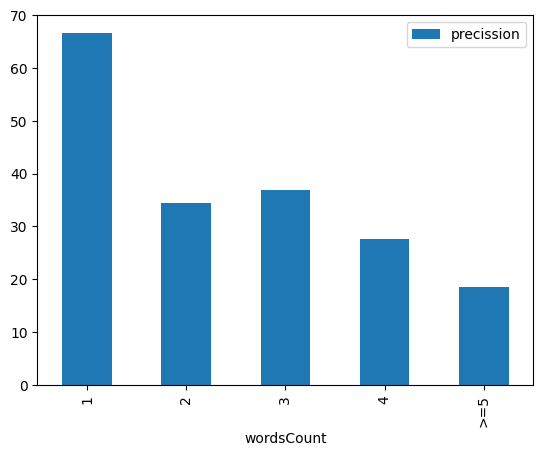

In [19]:
results_by_len = linking_and_result.groupby(by="wordsCount")[["numRight", "numLinking", "shouldLink"]].sum()
results_by_len["totalCount"] = linking_and_result.groupby(by="wordsCount")["text"].count()
results_by_len["num_words"] = results_by_len.index * results_by_len["totalCount"]

n_right, n_linking, s_link, totalCount, n_words = 0, 0, 0, 0, 0
for i in results_by_len.index:
    if i < 5:
        continue
    n_right += results_by_len["numRight"][i]
    n_linking += results_by_len["numLinking"][i]
    s_link += results_by_len["shouldLink"][i]
    totalCount += results_by_len["totalCount"][i]
    n_words += results_by_len["num_words"][i]
    
results_by_len.loc[">=5"] = {"wordsCount":">=5", "numRight": n_right,
                             "numLinking": n_linking, "shouldLink": s_link,
                             "totalCount": totalCount, "num_words": n_words}
results_by_len = results_by_len.drop([i for i in results_by_len.index if type(i) is type(3) and i >= 5])


results_by_len["precission"] = results_by_len.apply(lambda x: x.numRight / x.numLinking * 100, axis=1)
results_by_len["recall"] = results_by_len.apply(lambda x: x.numRight / x.shouldLink * 100 , axis=1)
results_by_len["F1"] = results_by_len.apply(lambda x: 2 * x.recall * x.precission / (x.recall + x.precission)
                                            if x.recall + x.precission != 0 else 0, axis=1)
results_by_len["precissionWithEmpty"] = results_by_len.apply(lambda x: (x.num_words - x.numLinking + x.numRight) / x.num_words * 100, axis=1)

results_by_len["precission"] = results_by_len["precission"].apply(lambda x: round(x, 2))
results_by_len["recall"] = results_by_len["recall"].apply(lambda x: round(x, 2))
results_by_len["F1"] = results_by_len["F1"].apply(lambda x: round(x, 2))
results_by_len["precissionWithEmpty"] = results_by_len["precissionWithEmpty"].apply(lambda x: round(x, 2))

(results_by_len[["totalCount", "shouldLink", "precission", "recall", "F1"]].to_csv("csv_output/solution_bywords.csv", index_label="wordsCount"))
results_by_len.plot(y="precission", kind="bar")
results_by_len

In [20]:
doctor_annotating_len = linking_and_result.groupby(by="wordsCount")[["shouldLink"]].sum()
doctor_annotating_len["countLinkable"] = linking_and_result[linking_and_result["rightLinking"].apply(lambda x: len(x) != 0)].groupby(by="wordsCount")["text"].count()
doctor_annotating_len["totalCount"] = linking_and_result.groupby(by="wordsCount")["text"].count()
doctor_annotating_len["num_words"] = doctor_annotating_len.index * doctor_annotating_len["countLinkable"]

s_link, totalCount, countLinkable, n_words = 0, 0, 0, 0
for i in doctor_annotating_len.index:
    if i < 5:
        continue
    s_link += doctor_annotating_len["shouldLink"][i]
    totalCount += doctor_annotating_len["totalCount"][i]
    countLinkable += doctor_annotating_len["countLinkable"][i]
    n_words += doctor_annotating_len["num_words"][i]
    
doctor_annotating_len.loc[">=5"] = {"wordsCount":">=5", "shouldLink": s_link, "totalCount": totalCount, "countLinkable": countLinkable, "num_words": n_words}
doctor_annotating_len = doctor_annotating_len.drop([i for i in doctor_annotating_len.index if type(i) is type(3) and i >= 5])

doctor_annotating_len["rightLinkPerLinkableMention"] = doctor_annotating_len.apply(lambda x: round(x.shouldLink / x.countLinkable, 2), axis=1)

doctor_annotating_len

,shouldLink,countLinkable,totalCount,num_words,rightLinkPerLinkableMention
wordsCount,,,,,
1,18,18,19,18,1.00
2,22,17,29,34,1.29
3,28,21,29,63,1.33
4,28,19,22,76,1.47
>=5,29,16,22,105,1.81


In [21]:
doctor_annotating_cat = linking_and_result.groupby(by="cathegory")[["shouldLink", "wordsCount"]].sum()
doctor_annotating_cat["totalCount"] = linking_and_result.groupby(by="cathegory")["text"].count()
doctor_annotating_cat["countLinkable"] = linking_and_result[linking_and_result["rightLinking"].apply(lambda x: len(x) != 0)].groupby(by="cathegory")["text"].count()
doctor_annotating_cat["numUnlikable"] = doctor_annotating_cat.apply(lambda x: x.totalCount - x.countLinkable, axis=1)

doctor_annotating_cat["rightLinkPerLinkableMention"] = doctor_annotating_cat.apply(lambda x: round(x.shouldLink / x.countLinkable, 2), axis=1)

doctor_annotating_cat.loc[["procedura", "medikace", "symptom",
           "osobní anamnéza", "NE medikace", "NE symptom",
           "NE osobní anamnéza"]].to_csv("csv_output/dataset_stats.csv", index_label="cathegory")
doctor_annotating_cat

,shouldLink,wordsCount,totalCount,countLinkable,numUnlikable,rightLinkPerLinkableMention
cathegory,,,,,,
NE medikace,3,23,10,3,7,1.00
NE osobní anamnéza,18,64,21,16,5,1.12
NE symptom,22,95,20,13,7,1.69
medikace,19,31,18,17,1,1.12
osobní anamnéza,21,60,17,14,3,1.50
procedura,24,49,17,15,2,1.60
symptom,18,68,18,13,5,1.38


In [22]:
print(doctor_annotating_cat["shouldLink"].sum())
print(doctor_annotating_cat["totalCount"].sum())
print(doctor_annotating_cat["countLinkable"].sum())
print(round(doctor_annotating_cat["shouldLink"].sum() / doctor_annotating_cat["countLinkable"].sum(), 2))

125
121
91
1.37
